In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [2]:
df = pd.read_csv("/content/Task 3 Loan_Data.csv")
df.head()


,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


In [20]:
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10000 non-null  int64  
 1   credit_lines_outstanding  10000 non-null  int64  
 2   loan_amt_outstanding      10000 non-null  float64
 3   total_debt_outstanding    10000 non-null  float64
 4   income                    10000 non-null  float64
 5   years_employed            10000 non-null  int64  
 6   fico_score                10000 non-null  int64  
 7   default                   10000 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 625.1 KB


,0
customer_id,0
credit_lines_outstanding,0
loan_amt_outstanding,0
total_debt_outstanding,0
income,0
years_employed,0
fico_score,0
default,0


In [22]:
df.columns

Index(['customer_id', 'credit_lines_outstanding', 'loan_amt_outstanding',
       'total_debt_outstanding', 'income', 'years_employed', 'fico_score',
       'default'],
      dtype='object')

# Prepare Features + Target

In [21]:
df = df.dropna()

target_column = "default"   # your dataset's target column
loan_column = "loan_amt_outstanding"   # your exposure column

y = df[target_column]
X = df.drop(columns=[target_column, "customer_id"])  # customer_id not needed


# Scale Features

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X_scaled, y, test_size=0.2, random_state=42)


# Train Logistic Regression Model

In [28]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

# Model Evaluation

Accuracy: 0.996

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1652
           1       1.00      0.98      0.99       348

    accuracy                           1.00      2000
   macro avg       1.00      0.99      0.99      2000
weighted avg       1.00      1.00      1.00      2000



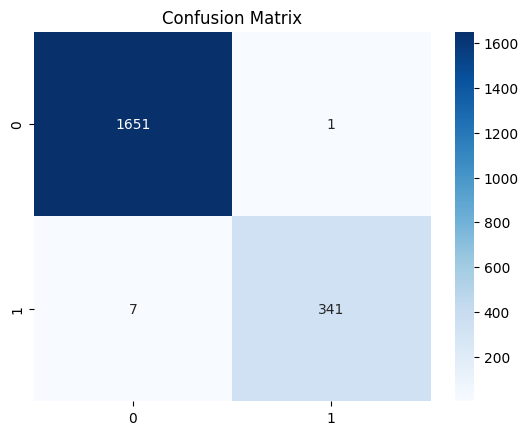

In [29]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


# Expected Loss Calculation

In [30]:
LGD = 0.90   # Loss Given Default = 90%

loan_amounts = X[loan_column].iloc[y_test.index]

expected_loss = y_proba * LGD * loan_amounts.values

expected_loss[:10]


array([1.42303939e-04, 4.29771037e+01, 4.80887369e+03, 1.09331194e-06,
       2.88489128e-05, 8.54124544e-07, 7.38684922e-05, 4.64332671e-05,
       4.29116693e+03, 8.42740332e-06])

# Show PD + Loan Amount + Expected Loss

In [31]:
results = pd.DataFrame({"Actual Default": y_test.values,"Predicted PD": y_proba,"Loan Amount": loan_amounts.values,"Expected Loss": expected_loss})
results.head()


,Actual Default,Predicted PD,Loan Amount,Expected Loss
0,0,4.410665e-08,3584.844437,0.000142
1,0,8.203450e-03,5821.006507,42.977104
2,1,1.000000e+00,5343.193215,4808.873689
3,0,8.273630e-10,1468.268561,0.000001
4,0,9.106413e-09,3519.975193,0.000029


# Final Expected Loss Function

In [33]:
def calculate_expected_loss(borrower_data):
    """borrower_data example:
    {
      "credit_lines_outstanding": 3,
      "loan_amt_outstanding": 20000,
      "total_debt_outstanding": 35000,
      "income": 65000,
      "years_employed": 4,
      "fico_score": 720
    }
    """
    df_input = pd.DataFrame([borrower_data])

    scaled = scaler.transform(df_input)

    pd_value = model.predict_proba(scaled)[:, 1][0]

    exposure = borrower_data["loan_amt_outstanding"]

    LGD = 0.90

    expected_loss = pd_value * LGD * exposure
    return expected_loss


# Test the Final Function

In [35]:
sample = {"credit_lines_outstanding": 2,"loan_amt_outstanding": 15000,"total_debt_outstanding": 20000,"income": 55000, "years_employed": 3,"fico_score": 690}

calculate_expected_loss(sample)


np.float64(8934.853147685186)